## Cardioid Beads
### 1. Velocity grid data with spatial smoothing

For a 120 x 120 grid of points in 2d

Draw a circle around each point with radius equal to point separation  [or we could try twice the point separation]

KAM: I think it would make sense to make the diameter of the averaging circle equal to the length of an individual fiber/chain.  That seems to be the appropriate length scale from the videos.  Then we could make the spacing between grid points equal to half that value (i.e. the radius of the averaging circle), so that the averaging circles overlap.  This should produce a smoother velocity field for the sake of taking derivatives.

Of course, we’ll need director field (or Q-tensor) as well.  You said you already had that data.  Did you average in a similar way?  

Measure average vx and vy for that data point for beads in that circle
Provide at least 100 frames from last part of the simulation
Output data for each gridpoint in each frame in this form…

i j vx vy 

Let us know if there a better data format.

KAM: This all looks good.

In [1]:
%matplotlib ipympl
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import spatial
from tqdm.auto import tqdm

In [2]:
#filename = "/media/matt/SCRATCH/ActiveMatterWorms/data_02_02_2024/filament_data.npz"

filename = "/media/matt/DATA/data_22_05_2024/filament_data.npz"
#filename = "/media/matt/DATA/osc_data/data_15_05_2024-2/filament_data.npz"
data = np.load(filename)
pos_data = data['a']
vel_data = data['b']
print(vel_data.shape)
N = data['a'].shape[1]
nframes = data['a'].shape[0]
print(N)
print(nframes)

(501, 144000, 3)
144000
501


In [3]:
def find_avg_vel_smoothed(iframe,pos_data,vel_data,bounds,X,Y,num_points=120):
    x_min,x_max,y_min,y_max = bounds
    #radius = X[0,1]-X[0,0]
    radius = 2.0*(X[0,1]-X[0,0])
    pts = np.c_[X.ravel(),Y.ravel()]
    tree = spatial.KDTree(pos_data[iframe,:,0:2])
    vx_avg = np.zeros((num_points,num_points))
    vy_avg = np.zeros((num_points,num_points))
    vmag_avg = np.zeros((num_points,num_points))
    for i in np.arange(num_points):
        for j in np.arange(num_points):
            dd, ii = tree.query([[X[i,j],Y[i,j]]],workers=8,k=len(pos_data[iframe,:,0:2]),distance_upper_bound=radius)
            if np.argmax(dd>x_max**2) > 1:
                vx_avg[i,j] = np.mean(vel_data[iframe,ii[0][:np.argmax(dd>x_max**2)],0])
                vy_avg[i,j] = np.mean(vel_data[iframe,ii[0][:np.argmax(dd>x_max**2)],1])
                vmag_avg[i,j] = np.sqrt(vx_avg[i,j]**2 + vy_avg[i,j]**2)
    return vx_avg,vy_avg,vmag_avg
iframe = -1
bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], 120),np.linspace(bounds[2], bounds[3], 120))
vx_avg,vy_avg,vmag_avg = find_avg_vel_smoothed(iframe,pos_data,vel_data,bounds,X,Y)

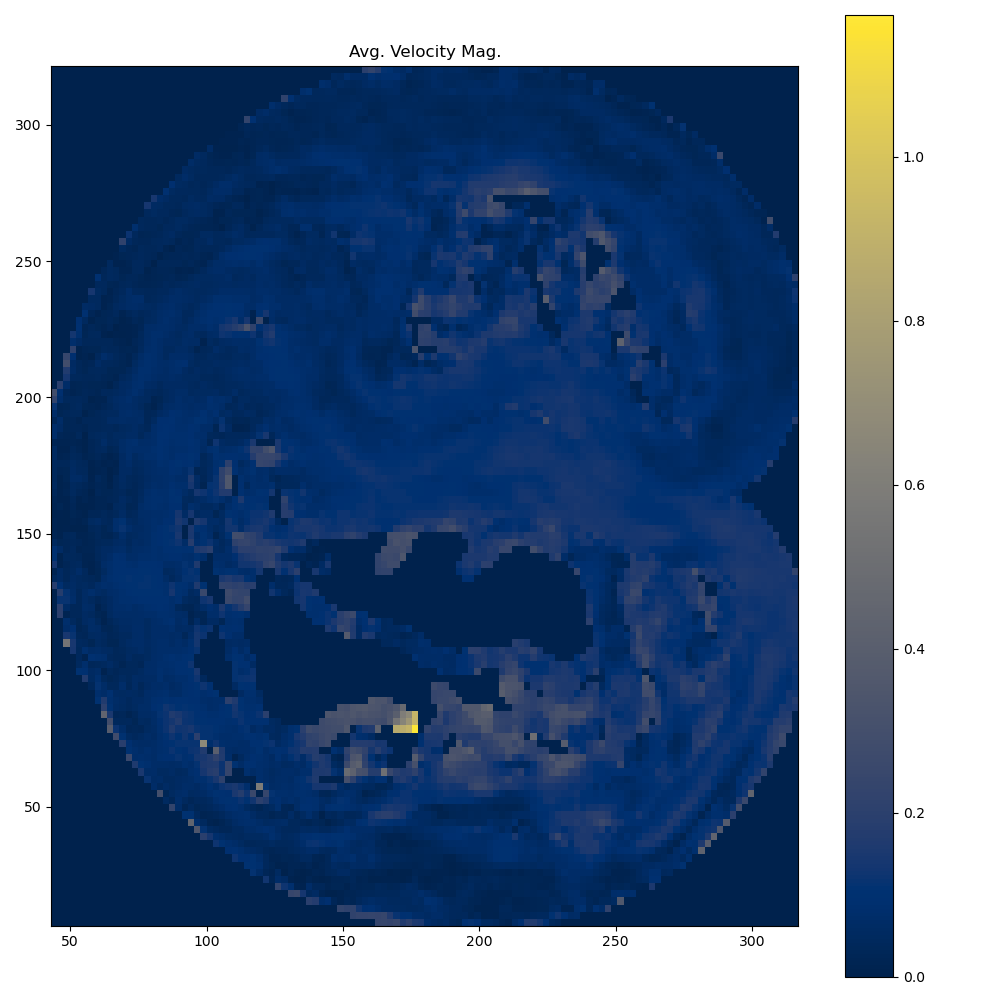

In [4]:
fig,axs = plt.subplots(1, 1,figsize=(10,10))
pcm = axs.imshow(vmag_avg,cmap="cividis",alpha=1.0,origin="lower",extent=bounds)#,interpolation='bicubic')
fig.colorbar(pcm, ax=axs)
axs.set_title("Avg. Velocity Mag.")
axs.set_ylim(bounds[2],bounds[3])
axs.set_xlim(bounds[0],bounds[1])
plt.tight_layout()
plt.show()

In [5]:
def write_avg_vel_ascii(istep,vx,vy,xs,ys,npoints,types="both"):
    filename = "vel_avg_"+str(istep).zfill(4)+".data"
    with open(filename, 'w') as file:
        file.write("# i j x y vx vy\n")
        for i in np.arange(0,npoints):
            for j in np.arange(0,npoints):
                #print(i,j,xs[i,j],ys[i,j],vx[i,j],vy[i,j])
                file.write(str(i)+"\t"+str(j)+"\t"+str(xs[i,j])+"\t"+str(ys[i,j])+"\t"+str(vx[i,j])+"\t"+str(vy[i,j])+"\n")

def write_avg_vel_npz(istep,vx_avg,vy_avg,X,Y):
    filename = "vel_avg_"+str(istep).zfill(4)
    np.savez(filename, x = X, y = Y, vx=vx_avg, vy=vy_avg)
    # npzfile = np.load(filename+".npz")
    # print(npzfile.files)

In [6]:
for iframe in tqdm(np.arange(301,len(pos_data[:,1,1]))):
    num_points = 120
    bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
    X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], num_points),np.linspace(bounds[2], bounds[3], num_points))
    vx_avg,vy_avg,vmag_avg = find_avg_vel_smoothed(iframe,pos_data,vel_data,bounds,X,Y)
    write_avg_vel_ascii(iframe,vx_avg,vy_avg,X,Y,num_points)
    write_avg_vel_npz(iframe,vx_avg,vy_avg,X,Y)

  0%|          | 0/200 [00:00<?, ?it/s]

### 2. Simulated photobleaching: starting at frame 1000, mark a skinny vertical rectangle of beads in a special color. Follow their trajectory with time. 

If that looks good, we are going to also create a vertical line of beads and track the total length along that line as time moves forward. Divide system in horizontal stripes. Find a bead in top stripe, add nearest bead in next stripe, etc. , connect with straight lines and calculate length.
The Lyapunov exponent is the slope of  ln(length) vs time where length is the sum of all the segment lengths. As beads move apart, any line segment exceeding a length limit will be broken into two segments by recruiting a new bead in between to add to the list. New bead is the one closest to the segment midpoint.

KAM: Another good way of doing the “photobleaching” would be to bleach a rectangular block of beads on the left of the horizontal axis (i.e. on the opposite side from the cusp).  This rectangle will then get pushed left against the boundary and will spread out along the boundary.   One could then measure the growth rate of the length of the bleached spot along the boundary and the rate of compression of the spot against the boundary (which should both be equal by area conservation.)   These rates should equal the topological entropy/Lyapunov exponent.   The nice thing about this choice of rectangle is that it will persist for a while before getting mixed and distorted in the interior of the cardioid. 


184.80183436952788


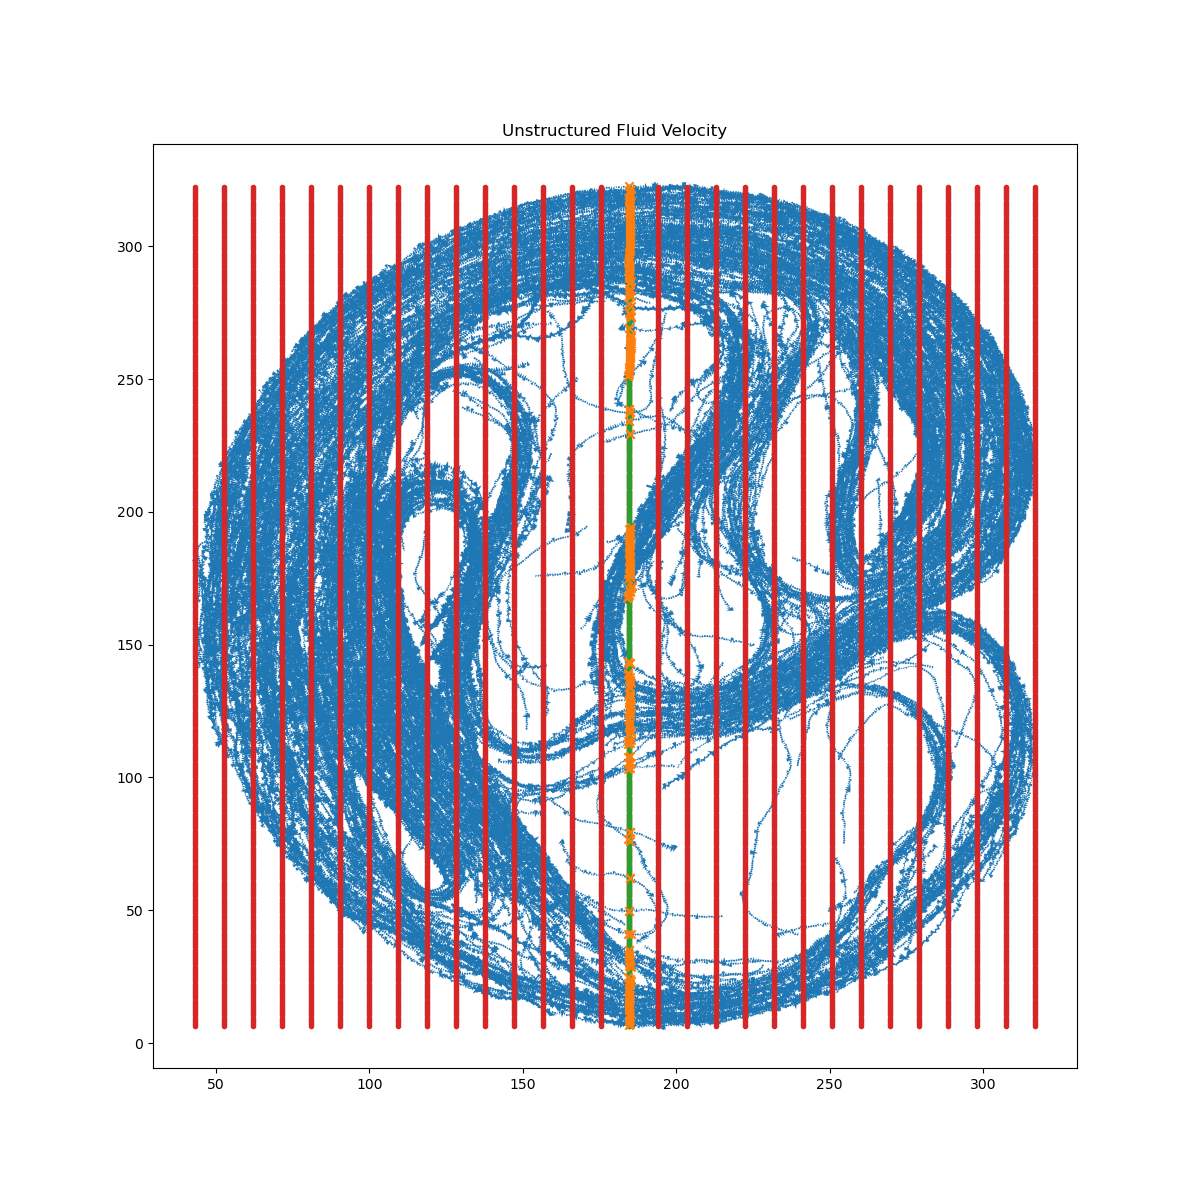

In [29]:
iframe = 301
length0=0.8
bounds = (np.min(pos_data[iframe,:,0]),np.max(pos_data[iframe,:,0]),np.min(pos_data[iframe,:,1]),np.max(pos_data[iframe,:,1]))
#X,Y = np.meshgrid(np.linspace(bounds[0], bounds[1], 30),np.linspace(bounds[2], bounds[3], 30))
X,Y = np.meshgrid(np.linspace(bounds[0],bounds[1],30),np.arange(bounds[2],bounds[3],0.8))
print(X[0,15])
tree = spatial.KDTree(pos_data[iframe,:,0:2])
pb_pts_x = []
pb_pts_y = []
for i in np.arange(len(X[:,15])):
    dd,ii = tree.query([[X[i,15],Y[i,25]]],workers=8,k=1,distance_upper_bound=length0)
    if dd < np.Inf:
        pb_pts_x.append(pos_data[iframe,ii,0])
        pb_pts_y.append(pos_data[iframe,ii,1])
        
    #print(dd,ii,sep="\n")


fig,ax = plt.subplots(1,1,figsize=(12,12))
quiver = ax.quiver(pos_data[iframe,:,0], #x
                   pos_data[iframe,:,1], #y
                   vel_data[iframe,:,0], #u
                   vel_data[iframe,:,1], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
#ax.scatter(X,Y,color="tab:red",marker='.')
ax.scatter(X[:,15],Y[:,15],color="tab:green",marker='.')
ax.scatter(pb_pts_x,pb_pts_y,color="tab:orange",marker='x')
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Fluid Velocity")
plt.show()


### 3. Trajectory analysis:

List x,y position of the head bead only for each filament, one frame at a time, for all frames.

KAM: Yes, that will allow us to apply our Etec algorithm to the bead trajectories.


In [28]:
np.Inf

inf